In [1]:
import pm4py, os

#import event logs
if __name__ == "__main__":
    log = pm4py.read_xes('BPI_Challenge_2019-3-w-after.xes')

parsing log, completed traces ::   0%|          | 0/15182 [00:00<?, ?it/s]

# Preprocessing

## Filter Definition

Used filters:

timeFrame filtering:
- filter out events not in [2018-01-0 ; 2019-01-28]
- implemented in filter_timeframe()

seperation of documentTypes:
- seperate traces into 3 event logs, one for each documentType
- implemented in group_by_documentType()

removal of incomplete cases:
- removes traces, that have not one of the specified start and end-activities
- EC Purchase order: 
    - Start Events: "Create Purchase Order Item", "Create Purchase Requisition Item", "SRM: Created", "Vendor creates invoice"
    - End Events: "Clear Invoice", "Delete Purchase Order Item"
- Framework order: 
    - Start Events: "Create Purchase Order Item", "Create Purchase Requisition Item", "Vendor creates invoice"
    - End Events: "Clear Invoice", "Delete Purchase Order Item"
- Standard PO: 
    - Start Events: "Create Purchase Order Item", "Create Purchase Requisition Item", "Vendor creates invoice"
    - End Events: "Clear Invoice", "Delete Purchase Order Item"

filtering out infrequent variants:
- remove variants, that only consist of one single case
- implemented in filter_out_infrequent_variants()

In [6]:
# exclude all traces that are not between 2018-01-0 and 2019-01-28
def filter_timeframe(log):
    return pm4py.filter_time_range(log, "2018-01-01 00:00:00", "2019-01-28 23:59:59", mode='traces_contained')

# group the eventlog by the values of the documentType attribute
def group_by_documentType(log):
    log_ecPurchaseOrder = pm4py.filter_trace_attribute_values(log, "(case) Document Type", ["EC Purchase order"], retain = True)
    log_frameworkOrder = pm4py.filter_trace_attribute_values(log, "(case) Document Type", ["Framework order"], retain = True)
    log_standardPO = pm4py.filter_trace_attribute_values(log, "(case) Document Type", ["Standard PO"], retain = True)
    return log_ecPurchaseOrder, log_frameworkOrder, log_standardPO


# removes traces, that have not one of the specified start and end-activities
def remove_incomplete_cases(log_ecPurchaseOrder, log_frameworkOrder, log_standardPO):
    
    # EC Purchase order
    log_ecPurchaseOrder = pm4py.filter_start_activities(log_ecPurchaseOrder, ["Create Purchase Order Item",
                    "Create Purchase Requisition Item", "SRM: Created", "Vendor creates invoice"])
    log_ecPurchaseOrder = pm4py.filter_end_activities(log_ecPurchaseOrder, ["Clear Invoice", "Delete Purchase Order Item"])
    
    # Framework order
    log_frameworkOrder = pm4py.filter_start_activities(log_frameworkOrder, ["Create Purchase Order Item",
                    "Create Purchase Requisition Item", "Vendor creates invoice"])
    log_frameworkOrder = pm4py.filter_end_activities(log_frameworkOrder, ["Clear Invoice", "Delete Purchase Order Item"])
    
    # Standard PO
    log_standardPO = pm4py.filter_start_activities(log_standardPO, ["Create Purchase Order Item",
                    "Create Purchase Requisition Item", "Vendor creates invoice"])
    log_standardPO = pm4py.filter_end_activities(log_standardPO, ["Clear Invoice", "Delete Purchase Order Item"])
    
    return log_ecPurchaseOrder, log_frameworkOrder, log_standardPO

def filter_out_infrequent_variants(log_ecPurchaseOrder, log_frameworkOrder, log_standardPO):
    
    # EC Purchase order
    log_ecPurchaseOrder = pm4py.filter_variants_by_coverage_percentage(log_ecPurchaseOrder, 0.0002)
    
    # Framework order
    log_frameworkOrder = pm4py.filter_variants_by_coverage_percentage(log_frameworkOrder, 0.01)
    
    # Standard PO
    log_standardPO = pm4py.filter_variants_by_coverage_percentage(log_standardPO, 0.0002)
    
    return log_ecPurchaseOrder, log_frameworkOrder, log_standardPO

#filter out variants, that only consist of events:
#     "Create Purchase Order Item", "Delete Purchase Order Item"
def filter_out_cpoi_dpoi(log):
    return pm4py.filter_variants(log, [["Create Purchase Order Item", "Delete Purchase Order Item"]], retain=False)

# write event log to a xes file in the preprocessed directory
def write_log_to_file(log, filename):
    path = os.path.join(os.path.dirname(os.getcwd()), 'Preprocessed', filename)
    pm4py.write_xes(log, path)
    
# export petri net as png
def write_pn_to_file(petri_net, initial_marking, final_marking, filename):
    path = os.path.join(os.path.dirname(os.getcwd()), "Process Discovery\\Inductive Miner", filename)
    pm4py.vis.save_vis_petri_net(petri_net=petri_net, initial_marking=initial_marking,
                             final_marking=final_marking, file_path=path)
    
#filter
def filter_srm_process(log):
    srm_events = ['SRM: Created', 'SRM: Incomplete','SRM: Held', 'SRM: Complete', 'SRM: Awaiting Approval',
                  'SRM: Document Completed', 'SRM: In Transfer to Execution System', 'SRM: Ordered',
                  ' SRM: Deleted', 'SRM: Change was Transmitted']
    return pm4py.filtering.filter_event_attribute_values(log=log, attribute_key='concept:name', values=srm_events,
                                                        level='event', retain=True)

## Preprocessing Pipeline

Process Discovery
1. timeFrame filtering
2. groupBy documentType
3. remove incomplete cases
4. filter out infrequent variants

Compliance: 3-way Matching:
1. timeFrame filtering
2. groupBy documentType
3. remove incomplete cases
4. Filter out variants: ["Create Purchase Order Item", "Delete Purchase Order Item"]

In [7]:
# 1. Filter on timeframe
filtered_log = filter_timeframe(log)

# 2. Group by documentType
log_ecPurchaseOrder, log_frameworkOrder, log_standardPO = group_by_documentType(filtered_log)

# 3. Remove incomplete cases
log_ecPurchaseOrder, log_frameworkOrder, log_standardPO = remove_incomplete_cases(log_ecPurchaseOrder, log_frameworkOrder, log_standardPO)


### Filtering for compliance: 3-way matching ###

#filter out variants: ["Create Purchase Order Item", "Delete Purchase Order Item"]
log_ecPurchaseOrder_3wayMatch = filter_out_cpoi_dpoi(log_ecPurchaseOrder)
log_frameworkOrder_3wayMatch = filter_out_cpoi_dpoi(log_frameworkOrder)
log_standardPO_3wayMatch = filter_out_cpoi_dpoi(log_standardPO)

# write filtered logs to files for 3-way Matching
write_log_to_file(log_ecPurchaseOrder_3wayMatch, 'EC Purchase order_3wayMatching.xes')
write_log_to_file(log_frameworkOrder_3wayMatch, 'Framework order_3wayMatching.xes')
write_log_to_file(log_standardPO_3wayMatch, 'Standard PO_3wayMatching.xes')



### Filtering for Preprocessing ###

# 4. Filter out infrequent variants
log_ecPurchaseOrder, log_frameworkOrder, log_standardPO = filter_out_infrequent_variants(log_ecPurchaseOrder, log_frameworkOrder, log_standardPO)

# write filtered logs to files
write_log_to_file(log_ecPurchaseOrder, 'EC Purchase order_discovery.xes')
write_log_to_file(log_frameworkOrder, 'Framework order_discovery.xes')
write_log_to_file(log_standardPO, 'Standard PO_discovery.xes')

exporting log, completed traces ::   0%|          | 0/346 [00:00<?, ?it/s]

exporting log, completed traces ::   0%|          | 0/232 [00:00<?, ?it/s]

exporting log, completed traces ::   0%|          | 0/8740 [00:00<?, ?it/s]

exporting log, completed traces ::   0%|          | 0/346 [00:00<?, ?it/s]

exporting log, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

exporting log, completed traces ::   0%|          | 0/7683 [00:00<?, ?it/s]

# Process Discovery

In [ ]:
### SRM Process ###

def mine_srm_process():
    
    # filter for srm process
    log_srm = filter_srm_process(log)

    # write log_srm to xes file
    write_log_to_file(log_srm, 'SRM-Process.xes')

# mine petrinet with inductive miner
net_srm, initial_marking_srm, final_marking_srm = pm4py.discovery.discover_petri_net_inductive(log_srm, noise_threshold = 0.0)

#view petrinet
pm4py.view_petri_net(net_srm, initial_marking_srm, final_marking_srm)
print("SRM Process\n\n\n\n")

# export petrinet to png file
write_pn_to_file(petri_net=net_srm, initial_marking=initial_marking_srm,
                 final_marking=final_marking_srm, filename="petriNet_SRM-Process.png")

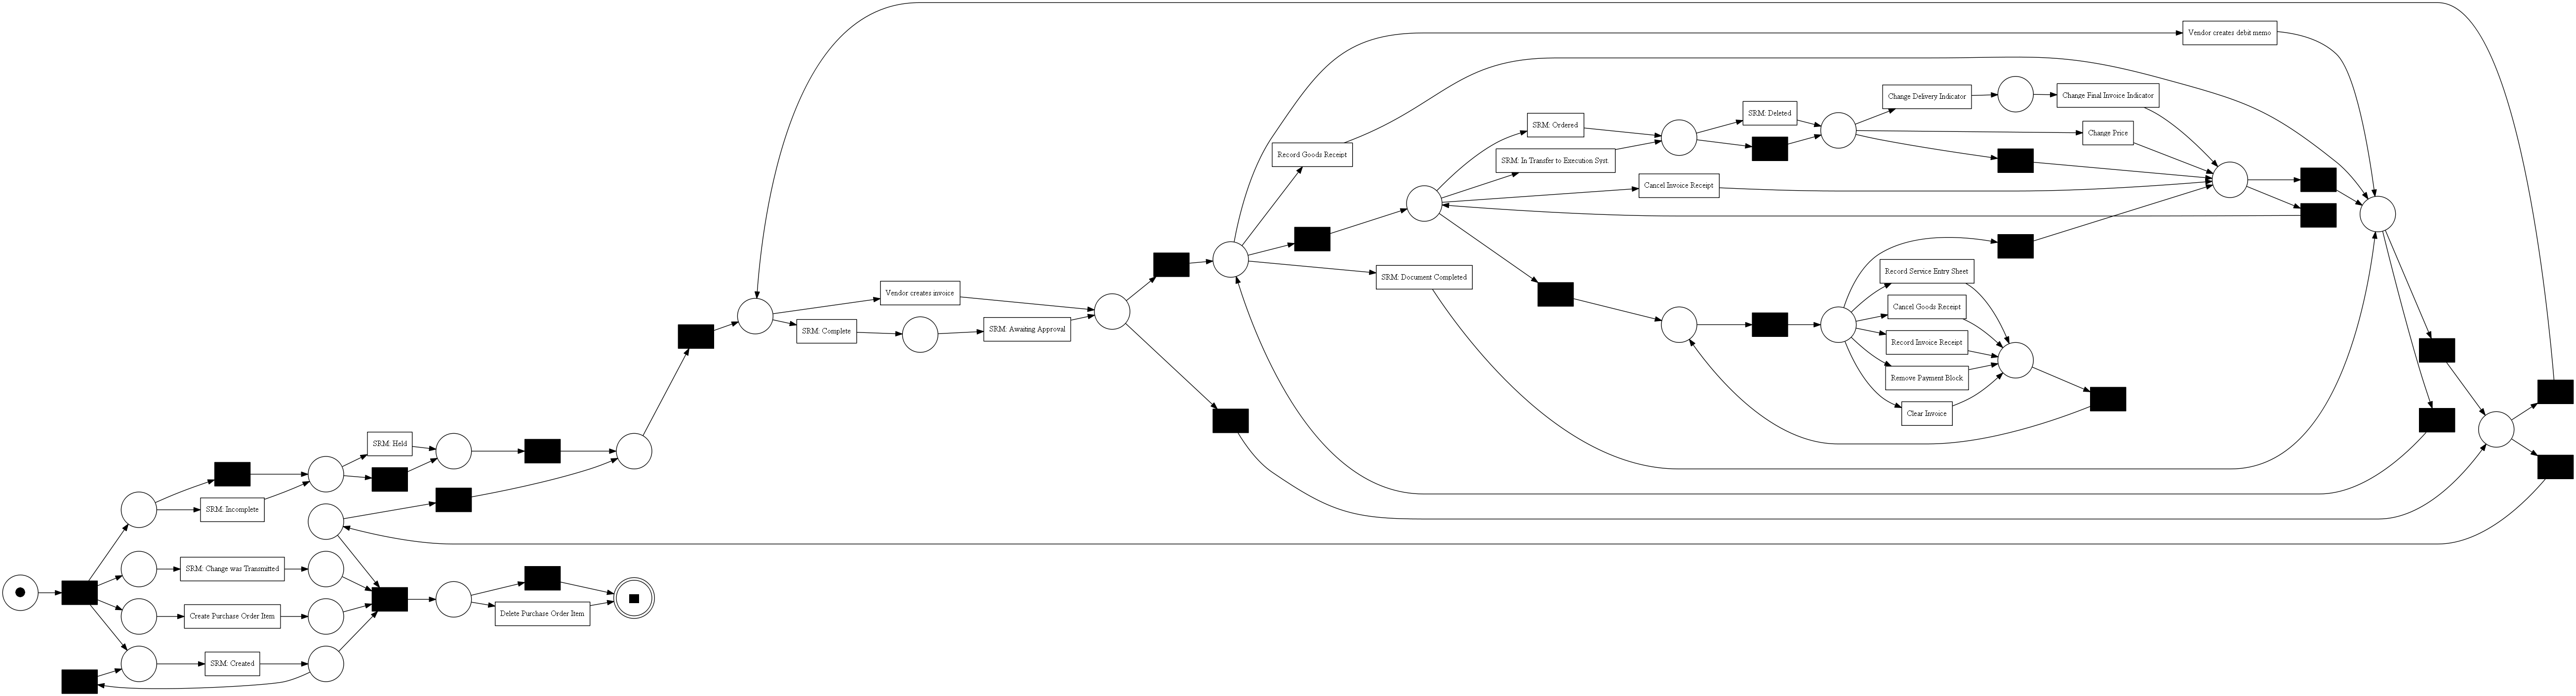

EC Purchase order






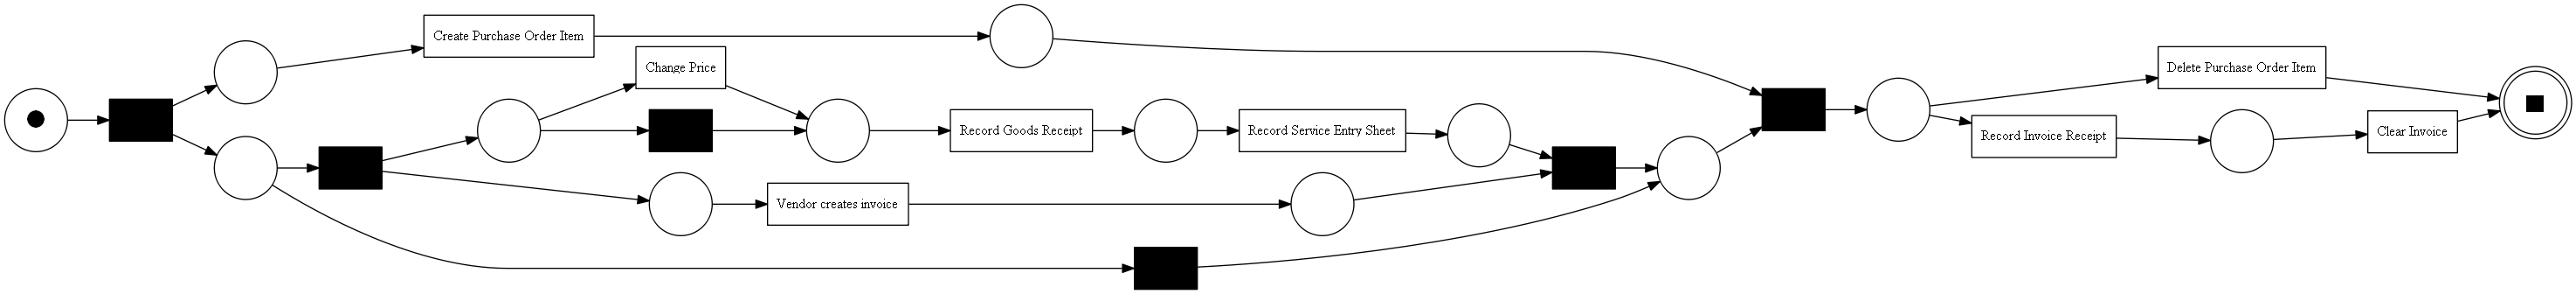

Framework order






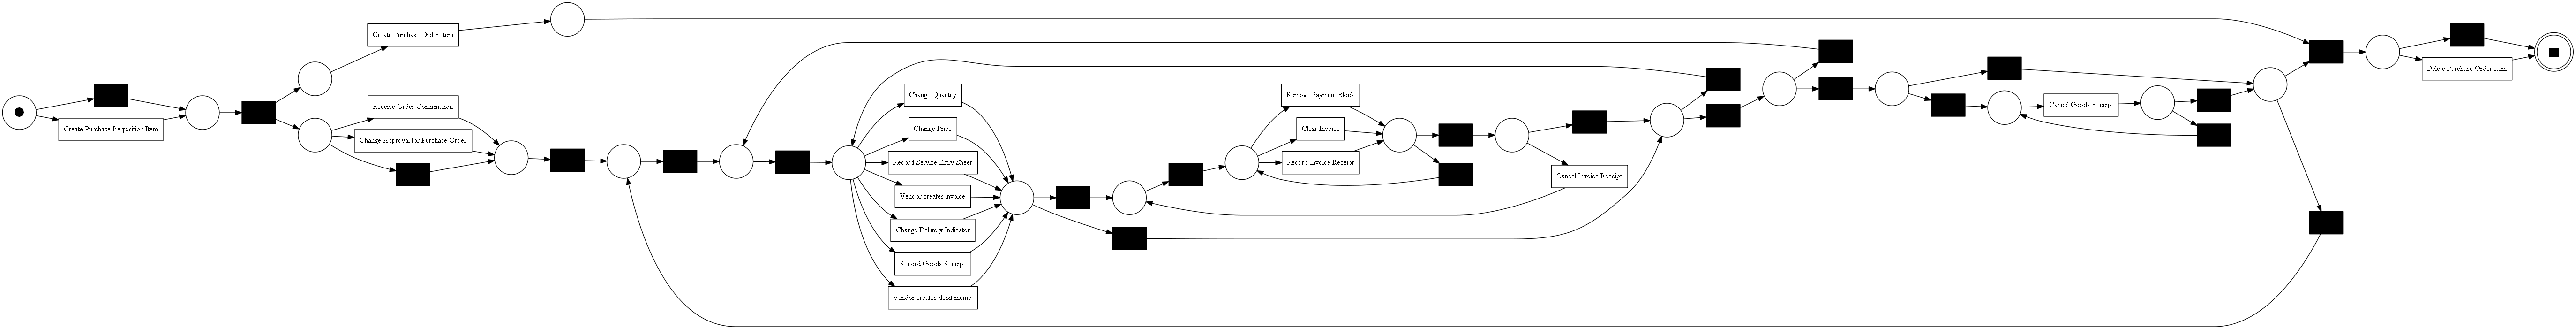

Standard PO






In [8]:
###### Inductive Miner (infrequent) ######


### EC Purchase order ###

# mine petrinet with inductive miner
net_ecPurchaseOrder, initial_marking_ecPurchaseOrder, final_marking_ecPurchaseOrder = pm4py.discovery.discover_petri_net_inductive(log_ecPurchaseOrder, noise_threshold = 0.0)

#view petrinet
pm4py.view_petri_net(net_ecPurchaseOrder, initial_marking_ecPurchaseOrder, final_marking_ecPurchaseOrder)
print("EC Purchase order\n\n\n\n")

# export petrinet to png file
write_pn_to_file(petri_net=net_ecPurchaseOrder, initial_marking=initial_marking_ecPurchaseOrder,
                 final_marking=final_marking_ecPurchaseOrder, filename="petriNet_ecPurchaseOrder.png")



### Framework order ###

# mine petrinet with inductive miner
net_frameworkOrder, initial_marking_frameworkOrder, final_marking_frameworkOrder = pm4py.discovery.discover_petri_net_inductive(log_frameworkOrder, noise_threshold = 0.2)

#view petrinet
pm4py.view_petri_net(net_frameworkOrder, initial_marking_frameworkOrder, final_marking_frameworkOrder)
print("Framework order\n\n\n\n")

# export petrinet to png file
write_pn_to_file(petri_net=net_frameworkOrder, initial_marking=initial_marking_frameworkOrder,
                 final_marking=final_marking_frameworkOrder, filename="petriNet_frameworkOrder.png")



### Standard PO ###

# mine petrinet with inductive miner
net_standardPO, initial_marking_standardPO, final_marking_standardPO = pm4py.discovery.discover_petri_net_inductive(log_standardPO, noise_threshold = 0.2)

#view petrinet
pm4py.view_petri_net(net_standardPO, initial_marking_standardPO, final_marking_standardPO)
print("Standard PO\n\n\n\n")

# export petrinet to png file
write_pn_to_file(petri_net=net_standardPO, initial_marking=initial_marking_standardPO,
                 final_marking=final_marking_standardPO, filename="petriNet_standardPO.png")